# Building a Binary Classifier

> In this example, the moons dataset is used to build a binary classifier.

In [ ]:
# |hide
from nbdev.showdoc import *

In [ ]:
# |hide
# Setup
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 300
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from mlmvn.layers import (
    FirstLayer,
    HiddenLayer,
    OutputLayer,
    cmplx_phase_activation,
    MyDropout,
)
from mlmvn.loss import ComplexMSELoss
from mlmvn.optim import MySGD, ECL

import wandb

torch.manual_seed(0)  #  for repeatable results

<torch._C.Generator>

In [ ]:
def accuracy(out, yb):
    out = out.type(torch.double)
    yb = yb.type(torch.double)
    x = 0
    for i in range(len(out)):
        x += torch.equal(out[i], yb[i])
    return x / len(out)


def angle2class(x: torch.tensor, categories: int, periodicity: int) -> torch.tensor:
    tmp = x.angle() + 2 * np.pi
    angle = torch.remainder(tmp, 2 * np.pi)

    # This will be the discrete output (the number of sector)
    o = torch.floor(categories * periodicity * angle / (2 * np.pi))
    return torch.remainder(o, categories)

## Dataset
In this example the moons dataset is used to build a binary classifcator. The aim is to find the boundary beetween two cresecent moons. The entire data set consists of 1500 data points and is shown in the image below. 

In [ ]:
# hide
n_samples = 1500
X, y = datasets.make_moons(n_samples=n_samples, noise=0.1, random_state=42)

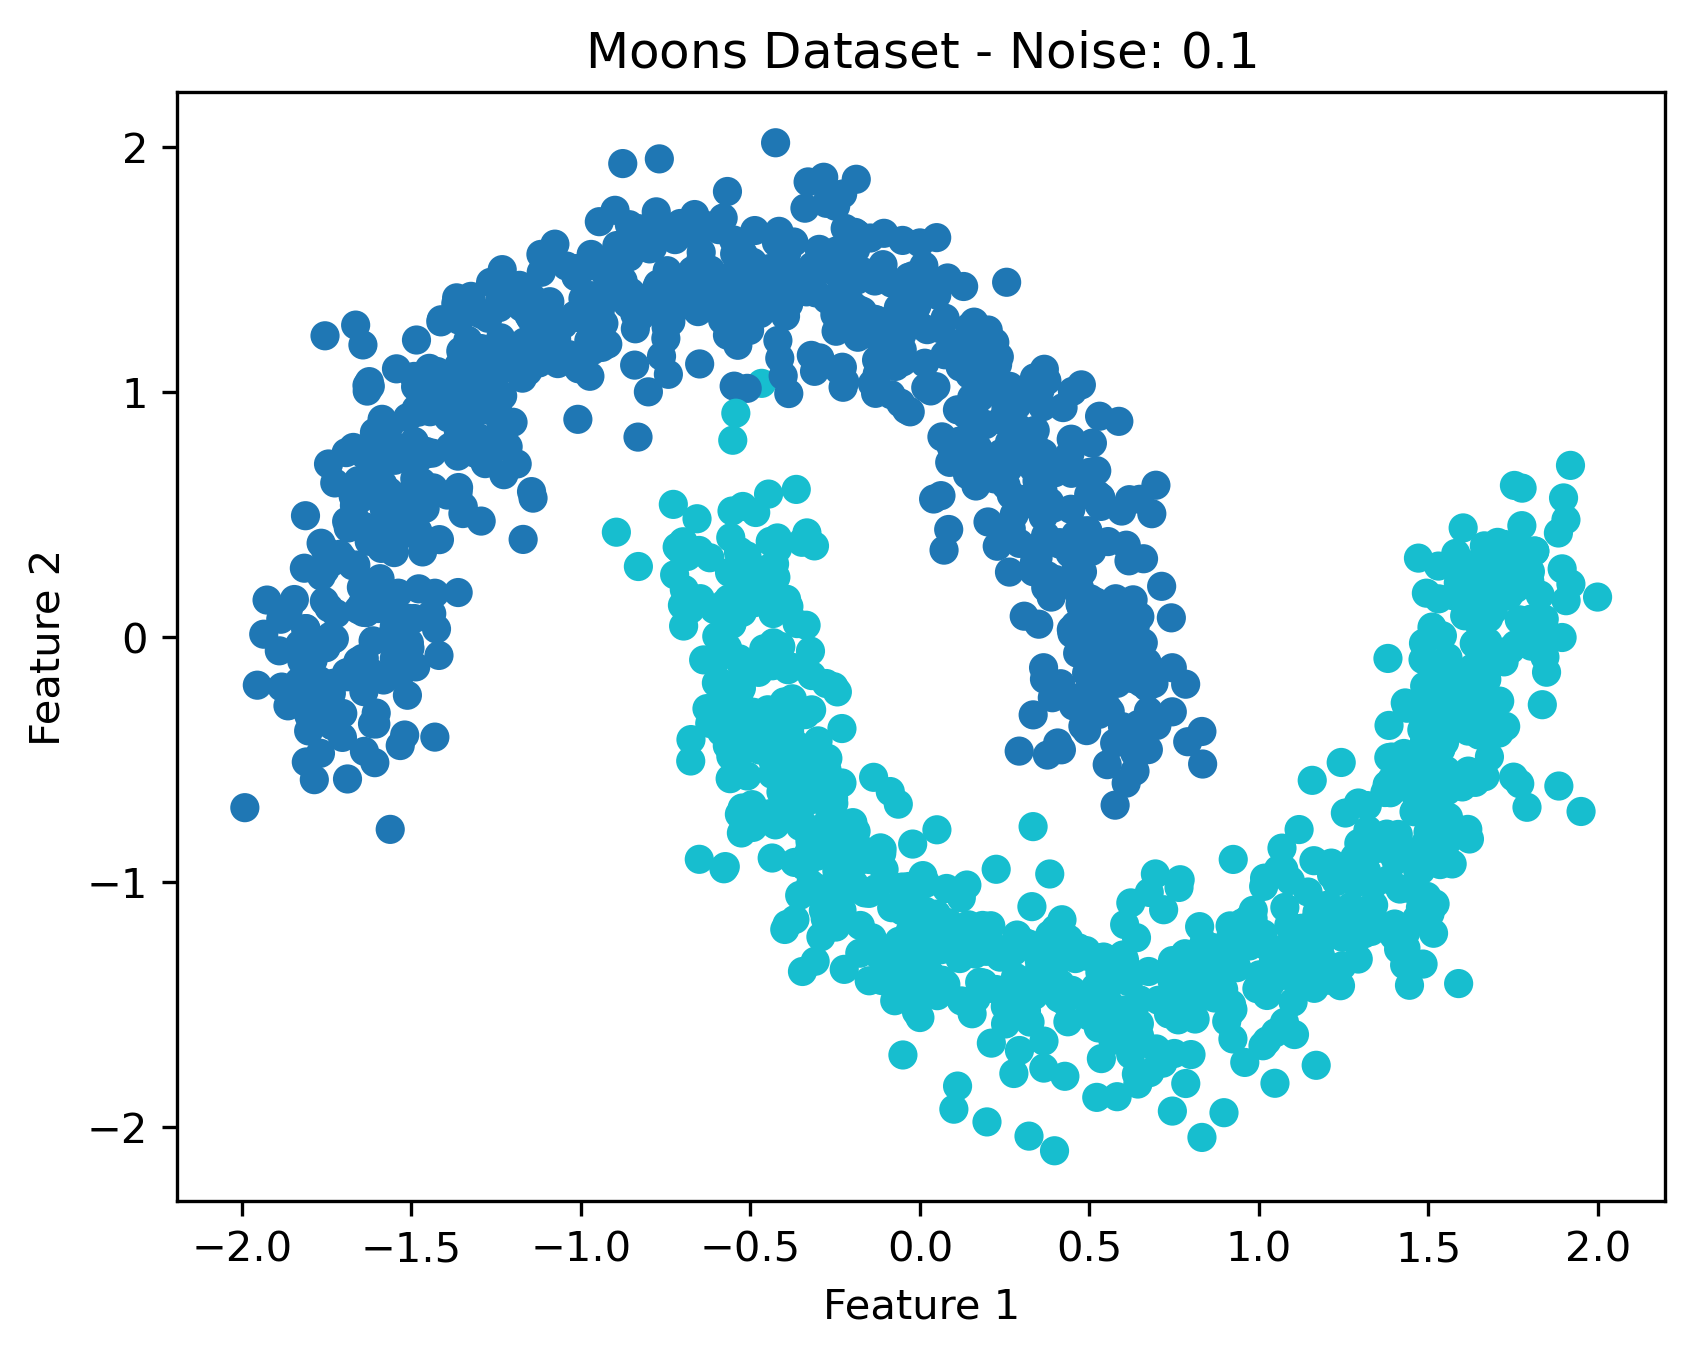

In [ ]:
# hide_input
#%matplotlib widget
X = StandardScaler().fit_transform(X)
# X = transform(X, alpha=np.pi / 8)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10")
plt.title("Moons Dataset - Noise: $0.1$")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid()
plt.show()

## MLMVN

In [ ]:
def backward_hook(module, grad_input, grad_output):
    print("module:", module)
    print("grad_input:", grad_input)
    print("grad_output:", grad_output)


model_dict: dict = {}


def fc_hook(layer_name, module, grad_input, grad_output):
    if layer_name in model_dict:
        model_dict[layer_name]["weights"].append(module.weights.detach().clone())
        model_dict[layer_name]["bias"].append(module.bias.detach().clone())
        model_dict[layer_name]["grad_input"].append(grad_input)
        model_dict[layer_name]["grad_output"].append(grad_output)
    else:
        model_dict[layer_name] = {}
        model_dict[layer_name]["weights"] = []
        model_dict[layer_name]["weights"].append(module.weights.detach().clone())
        model_dict[layer_name]["bias"] = []
        model_dict[layer_name]["bias"].append(module.bias.detach().clone())
        model_dict[layer_name]["grad_input"] = []
        model_dict[layer_name]["grad_input"].append(grad_input)
        model_dict[layer_name]["grad_output"] = []
        model_dict[layer_name]["grad_output"].append(grad_output)


class MLMVN(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_linear = FirstLayer(2, 5)
        self.phase_act1 = cmplx_phase_activation()
        # self.hidden_linear = HiddenLayer(4, 4)
        # self.phase_act2 = cmplx_phase_activation()
        self.output_linear = OutputLayer(5, 1)
        # self.dropout = MyDropout(0.25)
        self.phase_act3 = cmplx_phase_activation()
        self.first_layer_hook_handle = self.first_linear.register_backward_hook(
            self.first_layer_backward_hook
        )
        self.output_hook_handle = self.output_linear.register_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        # x = self.hidden_linear(x)
        # x = self.phase_act2(x)
        x = self.output_linear(x)
        # x = self.dropout(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(
        self, module, grad_input, grad_output
    ):  # module is Linear in this case. Ignored.
        fc_hook("first_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def predict(self, x, loss):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return output


# Implement the train function given a training dataset X and correcsponding labels y
def train(
    model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity
):
    # List of losses for visualization
    losses = []
    scores = []

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(xb)

            loss = criterion(y_pred, yb, categories, periodicity)

            if i % 10 == 9:
                print(torch.abs(loss))
            batch_loss.append((torch.abs(loss)).detach().numpy())

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        y_pred = model(X)
        y_pred = angle2class(y_pred, categories, periodicity)
        scores.append(accuracy(y_pred.squeeze(), y))

        log_dict = {
            "loss": torch.tensor(losses[-1]),
            "acc": torch.tensor(scores[-1]),
            "first_layer_weights_real": wandb.Histogram(
                model_dict["first_layer"]["weights"][-1].real
            ),
            "first_layer_bias_real": wandb.Histogram(
                model_dict["first_layer"]["bias"][-1].real
            ),
            "first_layer_weights_imag": wandb.Histogram(
                model_dict["first_layer"]["weights"][-1].imag
            ),
            "first_layer_bias_imag": wandb.Histogram(
                model_dict["first_layer"]["bias"][-1].imag
            ),
        }

        wandb.log(log_dict)

    return (
        losses,
        scores,
    )

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Convert numpy arrays into torch tensors
X_train_t, y_train_t, X_test_t, y_test_t = map(
    torch.tensor, (X_train, y_train, X_test, y_test)
)

X_train_t = X_train_t.type(torch.cdouble)
X_test_t = X_test_t.type(torch.cdouble)

In [ ]:
# start a new experiment
wandb.init(project="moons-model-mlmvn", entity="antonpf")

#  capture a dictionary of hyperparameters with config
wandb.config = {"learning_rate": 1, "epochs": 100, "batch_size": 100, "optim": "ecl"}

In [ ]:
model = MLMVN()
criterion = ComplexMSELoss.apply
# optimizer = torch.optim.SGD(model.parameters(), lr=1)
optimizer = ECL(model.parameters(), lr=1)
categories = 2
periodicity = 1

In [ ]:
(losses, scores,) = train(
    model,
    X_train_t,
    y_train_t,
    epochs=200,
    batch_size=100,
    optimizer=optimizer,
    criterion=criterion,
    categories=categories,
    periodicity=periodicity,
)
wandb.finish()

/home/antonp/anaconda3/envs/mlmvn/lib/python3.9/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


tensor(0.1526, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.1000, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.1031, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.1192, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.0791, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.2174, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.0440, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.2201, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.1058, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.0600, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.0316, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.0547, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.1015, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.0540, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.1542, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.0227, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.1092, dtype=torch.float64, grad

acc,▁▂▇▇▇▇▇▇▇█▇▇█▇█▇███▇█▇▇█▆▆▇▇█▇▇▇▇▇█▇▇▇▇▇
loss,█▆▃▂▂▂▂▁▂▂▂▃▁▁▁▁▁▁▁▂▂▂▂▁▃▂▁▁▁▁▁▂▂▂▁▁▁▁▁▁
acc,0.99778
loss,0.02497


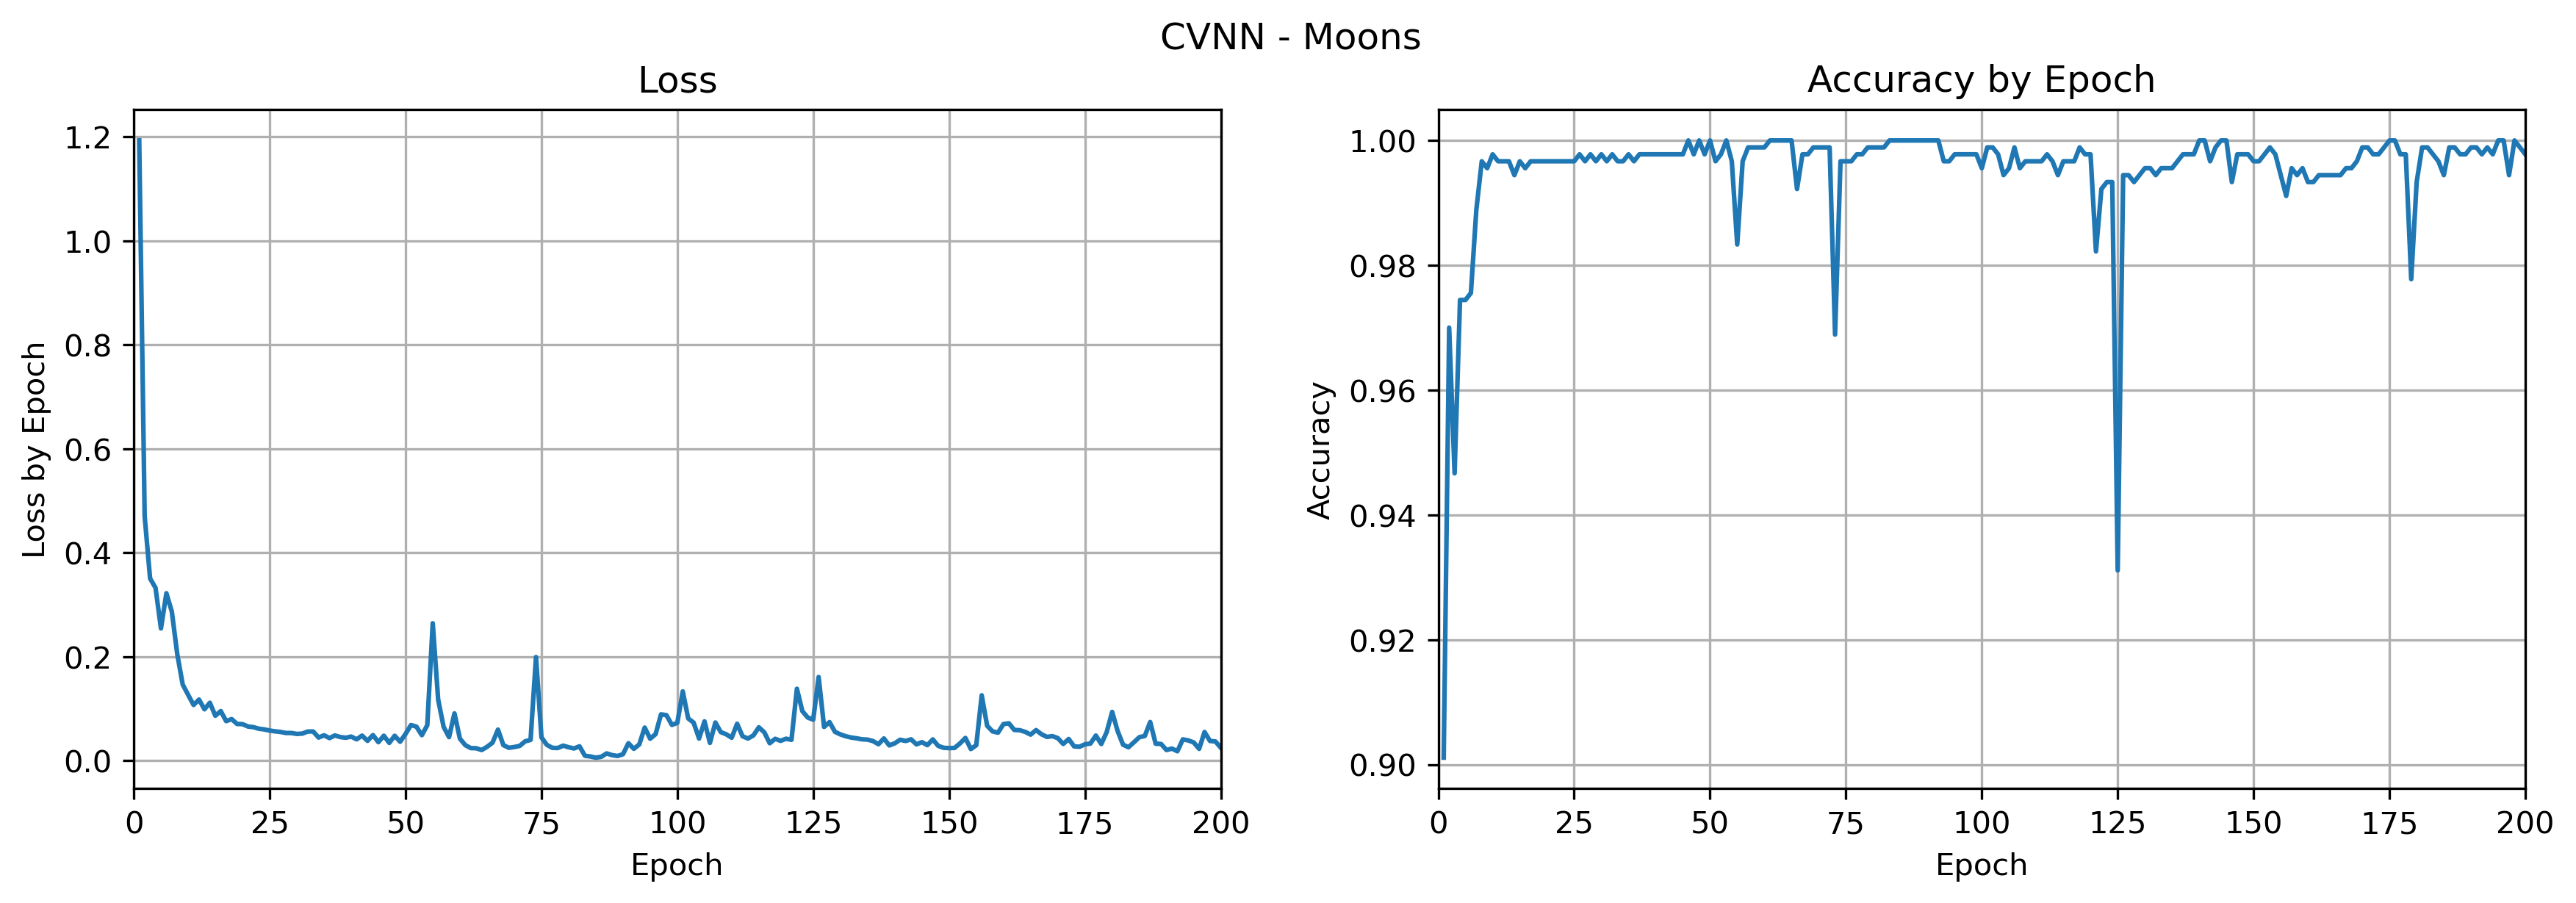

In [ ]:
def plot_loss(title, losses, scores):
    plt.rcParams["axes.grid"] = True
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle("CVNN - Moons")
    ax1.plot(np.linspace(1, len(losses), len(losses)), losses)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss by Epoch")
    ax1.set_title("Loss")
    ax1.set_xlim(0, len(losses))

    ax2.plot(np.linspace(1, len(scores), len(scores)), scores)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Accuracy by Epoch")
    ax2.set_xlim(0, len(losses))

    plt.show()


plot_loss("CVNN - Moons", losses, scores)

In [ ]:
# hide_input
def plot_weights(title, weights_real, weights_imag):
    y_min = np.min([np.min(weights_real), np.min(weights_imag)])
    y_max = np.max([np.max(weights_real), np.max(weights_imag)])

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 2))
    fig.suptitle(title)
    ax[0].plot(np.linspace(1, len(weights_real), len(weights_real)), weights_real)
    ax[0].set_xlabel("Step")
    ax[0].set_ylabel("Weight Value")
    ax[0].set_title("Real Valued Weigts")
    ax[0].set_xlim(0, len(weights_real))
    ax[0].set_ylim(y_min, y_max)

    ax[1].plot(np.linspace(1, len(weights_imag), len(weights_imag)), weights_imag)
    ax[1].set_xlabel("Step")
    ax[1].set_ylabel("Weight Value")
    ax[1].set_title("Imaginary Valued Weights")
    ax[1].set_xlim(0, len(weights_imag))
    ax[1].set_ylim(y_min, y_max)

    plt.show()

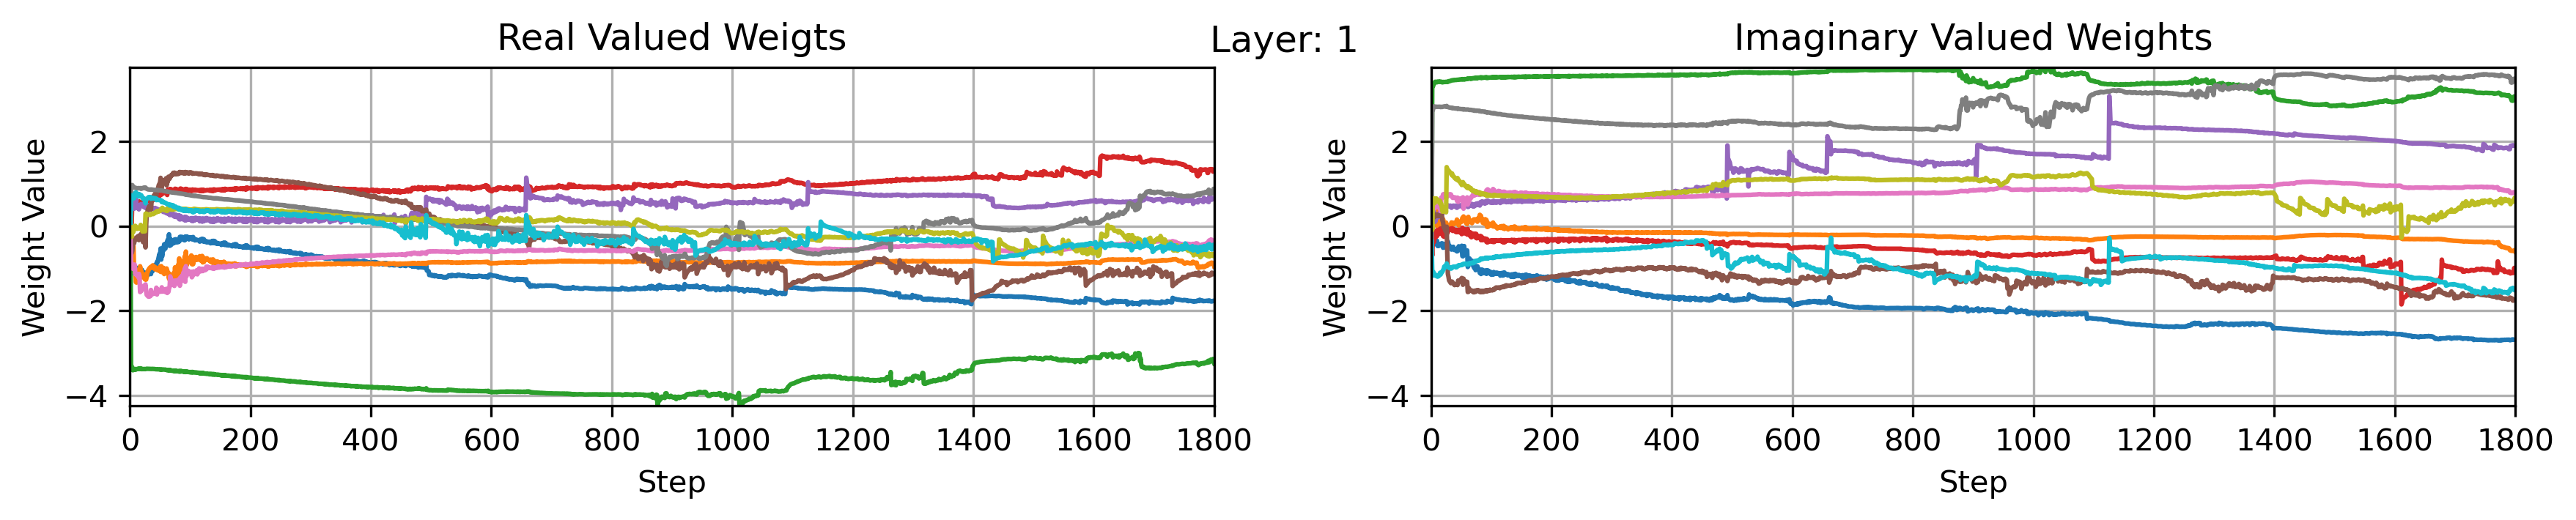

In [ ]:
list_weights = model_dict["first_layer"]["weights"]
list_bias = model_dict["first_layer"]["bias"]

weights = []
biases = []
for weight, bias in zip(list_weights, list_bias):
    # test = list_weights[0][0].flatten() + list_weights[0][1].flatten()
    weights.append(np.concatenate([weight.flatten()]))
    biases.append(np.concatenate([bias.flatten()]))

weights_real = np.real(weights)
weights_imag = np.imag(weights)


bias_real = np.real(biases)
bias_imag = np.imag(biases)

plot_weights("Layer: 1", weights_real, weights_imag)

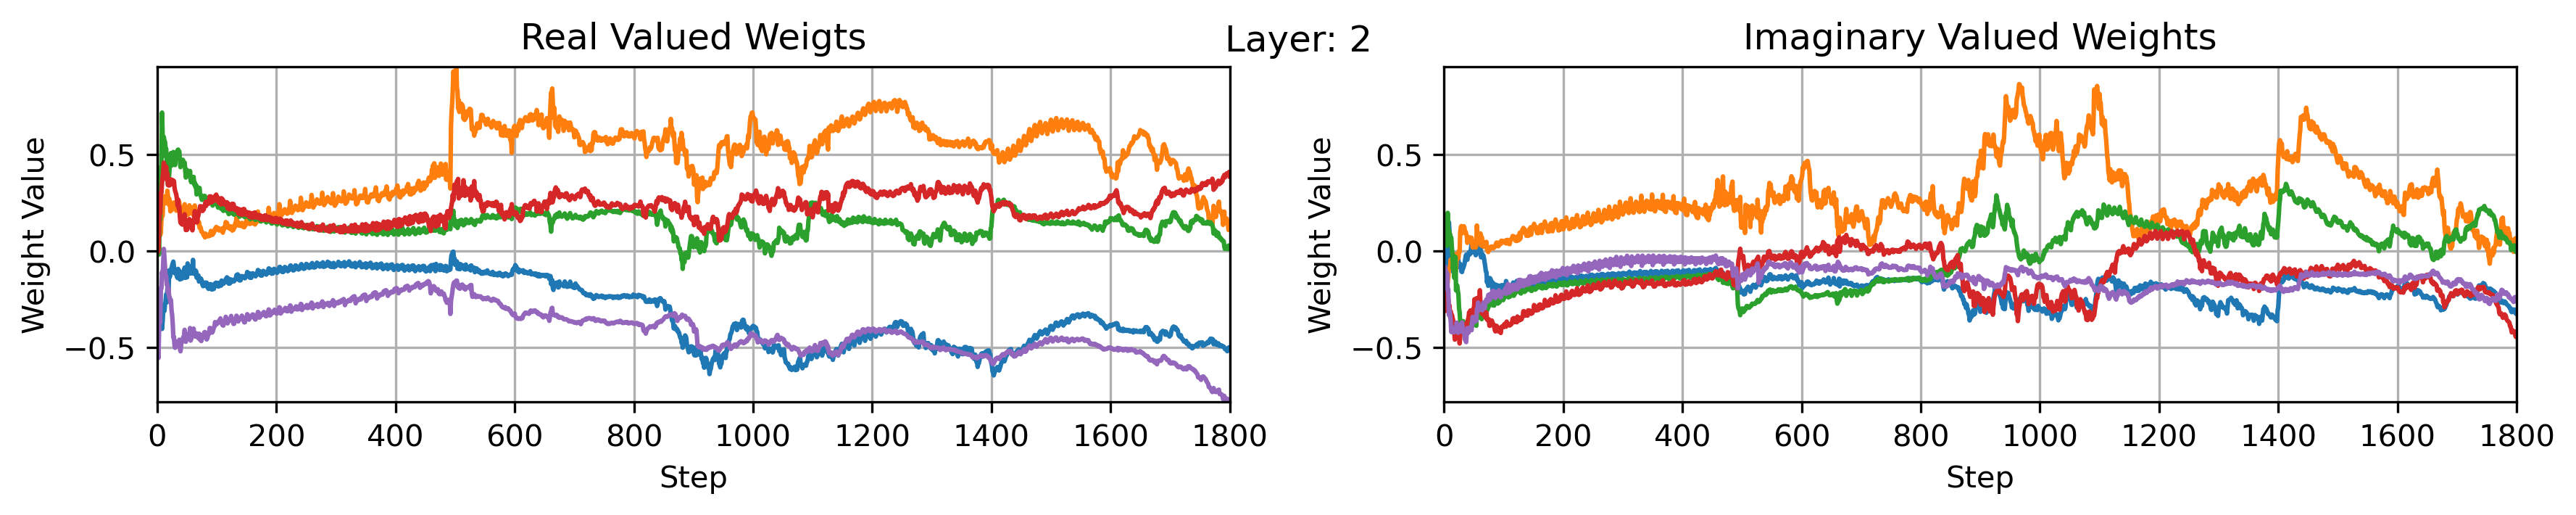

In [ ]:
list_weights = model_dict["output_layer"]["weights"]
list_bias = model_dict["output_layer"]["bias"]

weights = []
biases = []
for weight, bias in zip(list_weights, list_bias):
    # test = list_weights[0][0].flatten() + list_weights[0][1].flatten()
    weights.append(np.concatenate([weight.flatten()]))
    biases.append(np.concatenate([bias.flatten()]))

weights_real = np.real(weights)
weights_imag = np.imag(weights)


bias_real = np.real(biases)
bias_imag = np.imag(biases)

plot_weights("Layer: 2", weights_real, weights_imag)

In [ ]:
y_pred = model(X_train_t)
y_pred = angle2class(y_pred, categories, periodicity)
acc = accuracy(y_pred.squeeze(), y_train_t)
acc

0.9977777777777778

In [ ]:
y_pred = model(X_test_t)
y_pred = angle2class(y_pred, categories, periodicity)
acc = accuracy(y_pred.squeeze(), y_test_t)
acc

0.9933333333333333

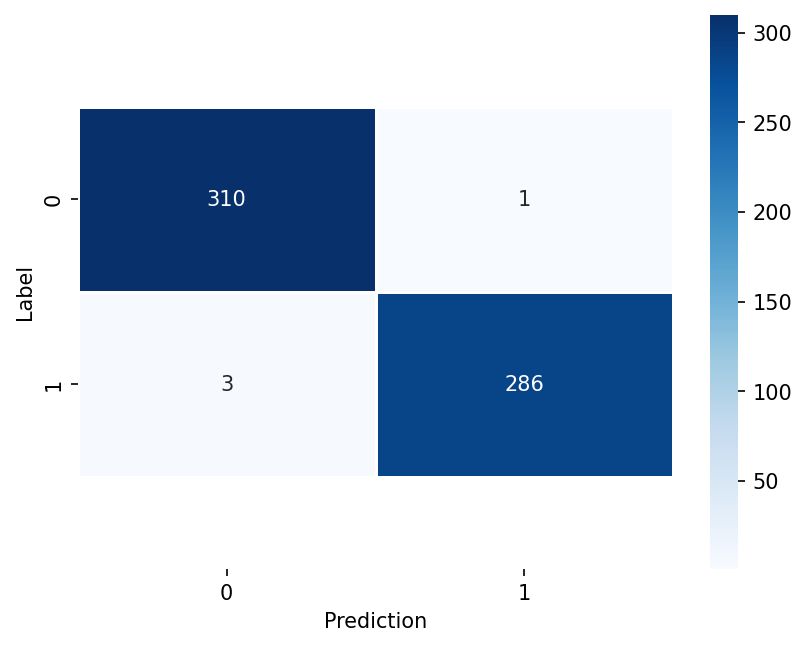

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       313
         1.0       0.99      1.00      0.99       287

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



In [ ]:
# hide_input
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred.detach().numpy())

ax = sns.heatmap(conf_mat, annot=True, fmt="g", linewidths=0.5, cmap=plt.cm.Blues)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel("Prediction")
plt.ylabel("Label")
# ax.figure.savefig('Dataset c3 - Model 48 - 1 - 3.png', dpi=300)
plt.show()

print(classification_report(y_pred.detach().numpy(), y_test))